<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/classification/gbm_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GBM(Gradient Boosting Machine)
### : 부스팅 알고리즘은 여러 개의 약한 학습(weak learner)를 순차적으로 학습-예측 하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가는 방식

대표적인 알고리즘
- AdaBoost(Adaptive boosting)
- 그래디언트 부스트

## AdaBoost 학습과정
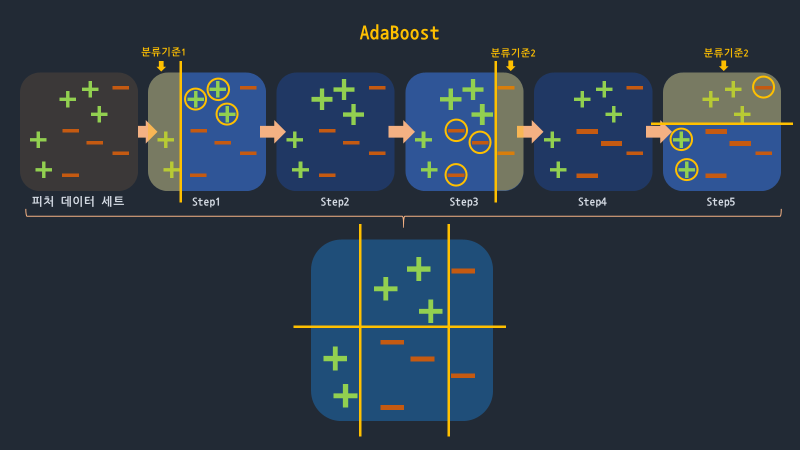

- Step1 : 첫 번째 약한 학습기가 분류 기준 1로 +와 -를 분류
  - 동그라미로 표시된 데이터는 + 데이터가 잘못 분류된 오류 데이터
- Step 2 : 이 오류 데이터에 대해서 가중치를 부여
  - 가중치로 부여된 오류 + 데이터는 다음 약한 학습기가 더 잘 분류할 수 있게 더 커짐
- Step 3 : 두 번째 약한 학습기가 분류 기준 2로 +와 -를 분류
  - 동그라미로 표시된 - 데이터는 잘못 분류된 오류 데이터
- Step 4 : 잘못 분류된 - 오류 데이터에 대해 약한 학습기가 더 잘 분류할 수 있게 더 큰 가중치를 부여
- Step 5 : 세 번째 약한 학습기가 분류 기준 3으로 +와 -를 분류하고 오류 데이터를 찾음
   - AdaBoost는 이렇게 약한 학습기가 **순차적으로 오류 값에 대해 가중치를 부여한 예측 결정 기준을 모두 결합해 예측을 수행**
- 마지막으로 맨 아레에는 모든 약한 학습기를 결합한 예측 결과
  - 개별 약한 학습기 보다 더 높은 정확도를 보임

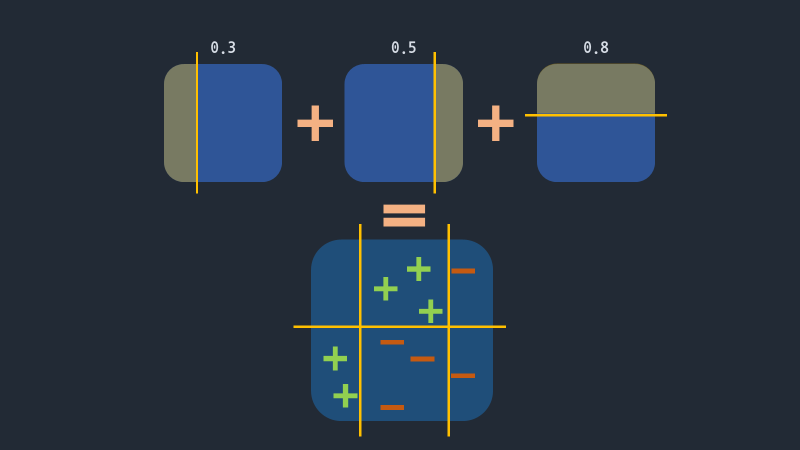

개별 약한 학습기는 각각 가중치를 부여해 결합
- 첫번째 학습기에는 **0.3의 가중치**
- 두번째 학습기에는 **0.5의 가중치**
- 세번째 학습기에는 **0.8의 가중치**

GBM도 AdaBoost와 유사하나 가중치 업데이트를 경사하강법(Gradient Descent)을 이용하는 것이 큰 차이이다.
- 오류 값은 실제 값 - 예측값이다. 분류의 실제 결과값을 $y$, 피처를 $x_1,x_2,x_3 ... x_n$ 그리고 이 피처에 기반한 예측 함수를 $F(x)$함수라고 하면
  - 오류 식은 $h(x) = y - F(x)$
- 경사하강법(Gradient Descent) : 위의 오류식($h(x) = y - F(x)$)을 최소화하는 방향성을 가지고 반복적으로 가중치 값을 업데이트 하는 것
  - 반복 수행을 통해 오류를 최소화 할 수 있도록 가중치의 업데이트 값을 도출하는 기법

## GBM 실습
- 사용자 행동 인식 데이터 세트를 활용
  - get_human_dataset()을 활용

In [2]:
import pandas as pd
### features.txt 파일에 있는 컬럼명을 입력 받아서 중복된 컬럼명은 원본 컬럼명+_1, _2와 같이 중복된 차수를 원본 컬럼명에 더해서 컬럼명을 update 하는 함수임. . 
def get_new_feature_name_df(old_feature_name_df):
    #column_name으로 중복된 컬럼명에 대해서는 중복 차수 부여, col1, col1과 같이 2개의 중복 컬럼이 있을 경우 1, 2 
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    # feature_dup_df의 index인 column_name을 reset_index()를 이용하여 컬럼으로 변환. 
    feature_dup_df = feature_dup_df.reset_index()
    # 인자로 받은 features_txt의 컬럼명 DataFrame과 feature_dup_df를 조인. 
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    # 새로운 컬럼명은 앞에 중복 차수를 접미어로 결합. 
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [3]:
def get_human_dataset():
 
  file_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/uci_humal_activity/features.txt"
  #각 데이터 파일들은 공백으로 구분되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
  feature_name_df = pd.read_csv(file_path, sep='\s+', header=None, names=["column_index", "column_name"])
  

 #중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
  #DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 반환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  #학습 피처 데이터 세트(X_train) / 테스트 피처 데이터 세트(X_test)를 DataFrame으로 로딩
  #칼럼명은 feature_name을 사용
  X_train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/uci_humal_activity/train/X_train.txt"
  X_test_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/uci_humal_activity/test/X_test.txt"
  X_train = pd.read_csv(X_train_path, sep='\s+',names = feature_name)
  X_test = pd.read_csv(X_test_path, sep='\s+',names = feature_name)

  #학습 레이블 데이터(y_train) / 테스트 레이블 데이트(y_test)를 DataFrame으로 로딩
  #칼럼명은 action으로 사용
  y_train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/uci_humal_activity/train/y_train.txt"
  y_test_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/uci_humal_activity/test/y_test.txt"
  y_train = pd.read_csv(y_train_path, sep='\s+', header = None, names=["action"])
  y_test = pd.read_csv(y_test_path, sep='\s+', header = None, names=["action"])

  #로드된 학습/테스트용 DataFrame 모두 반환
  return X_train, X_test, y_train, y_test

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
#GBM 수행 시간 측정을 위함
import time
import warnings

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()
#시작 시간 설정
start_time =time.time()

clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print("GBM 정확도 : {}".format(round(accuracy, 4)))
print("GBM 수행시간 : {}".format(time.time() - start_time))

GBM 정확도 : 0.9386
GBM 수행시간 : 810.8577542304993


기본 하이퍼 파라미터값으로 93%의 예측 정확도를 나타냅니다.
- GBM이 랜덤포레스트보다 성능이 좋은 경우도 많습니다.

하지만 GBM은 수행시간이 오래 걸리며, 하이퍼 파라미터 튜닝 노력도 더 필요합니다. 

## GBM 하이퍼 파라미터 튜닝
###파라미터(Parameters)
- loss
  - 경사하강법에서 사용할 비용함수를 지정
    - 특별한 이유가 없으면 기본값이 'deviance'를 그대로 적용
- learning_rate
  - GBM이 학습을 진행할 때 마다 적용하는 학습률
    - 약한 학습기가 순차적으로 오류 값을 보정해 나가는데 적용하는 계수
    - 0~1의 값을 지정할 수 있으며 defualt = 0.1 이다.
    - 너무 작은 값을 입력하면 업데이트 되는 값이 작아져서 최소 오류 값을 찾아 예측 성능이 높아질 수 있음
      - 하지만 너무 많은 약한 학습기가 순차적인 반복이 필요해서 수행시간이 오래 걸림
      - 또한 모든 약한 학습기가 반복이 완료되어도 최소 오류값을 찾지 못할 수 있음
    - 너무 큰 값을 입력하면 최소 오류 값을 찾지 못하고 그냥 지나쳐 버러 예측 성능이 떨어질 가능성이 높음
      - 빠른 수행이 가능함
    - n_estimators와 상호 보완적으로 조합해 사용
      - learning_rate를 작게 하고, n_estimators를 크게 하면 더 이상 성능이 좋아지지 않는 한계점까지는 예측성능이 조금씩 좋아질 수 있음
        - 하지만 수행시간이 너무 오래 걸리는 단점이 있음 
        - 또한 예측 성능 또한 현격하게 좋아지지는 않음
- n_estimators
  - 약한 학습기의 개수
    - 약한 학습기가 순차적으로 오류를 보정하므로 개수가 많을 수록 예측 성능이 일정 수준까지는 좋아질 수 있음
      - default = 100
        - 개수가 많을수록 수행 시간이 오래 걸림
- subsample
  - 약한 학습기가 학습에 사용하는 데이터의 샘플링 비율
    - default = 1
      - 이것은 전체 학습 데이터를 기반으로 학습한다는 의미
        - 0.5면 학습 데이터의 50%
  - 과적합이 염려되는 경우 1보다 작은 값으로 설정

In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators" : [100, 500],
    "learning_rate" : [0.05, 0.1]
}

grid = GridSearchCV(clf, param_grid = params, cv=2, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print("최적 하이퍼 파라미터 : \n",grid.best_params_)
print("최고 예측 정확도 : {}".format(round(grid.best_scores_, 4)))

In [5]:
pred = grid.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("GBM 정확도 : {}".format(round(accuracy, 4)))

GBM은 과적합에도 강한 뛰어난 예측 성능을 가진 알고리즘 이지만 수행시간이 오래걸린다는 단점을 가지고 있음